# Models utilitzant només les variables meteorològiques i de contaminació

In [117]:
import pandas as pd

X_train_std = pd.read_csv("./preprocessed_datasets/X_train_std_no_deleted.csv")
X_test_std = pd.read_csv("./preprocessed_datasets/X_test_std_no_deleted.csv")
y_train = pd.read_csv("./preprocessed_datasets/y_train.csv")
y_test = pd.read_csv("./preprocessed_datasets/y_test.csv")

The variable to predict, instead of performance, is going to be the percentage respect to that person's maximum performance. This way, we can really use the "environmental" variables and we try to avoid factors such as age, district...

In [118]:
import pandas as pd


train_df = pd.concat([X_train_std, y_train], axis=1)

train_max_performances = train_df.groupby('ID_Zenodo')['z_performance'].max()
train_df = train_df.merge(train_max_performances, left_on='ID_Zenodo', right_index=True, suffixes=('', '_max'))


min_performance = train_df['z_performance'].min()
train_df['y_percentage'] = (train_df['z_performance'] - min_performance) / (train_df['z_performance_max'] - min_performance)
train_df.drop(columns=['z_performance_max'], inplace=True)

# Same for test
test_df = pd.concat([X_test_std, y_test], axis=1)
test_df = test_df.merge(train_max_performances, left_on='ID_Zenodo', right_index=True, suffixes=('', '_max'))
#min_performance = test_df['z_performance'].min() # nose si això està be??
test_df['y_percentage'] = (test_df['z_performance'] - min_performance) / (test_df['z_performance_max'] - min_performance)

test_df.drop(columns=['z_performance_max'], inplace=True)

# test_df['y_percentage'] = test_df['y_percentage'].clip(0, 1) If you want to avoid values bigger than 1?


In [119]:
y_train = np.ravel(train_df["y_percentage"])
y_test = np.ravel(test_df["y_percentage"])

In [121]:
pollutionMeteo_columns = ['no2bcn_24h', 'no2bcn_12h', 'no2gps_24h',
       'no2gps_12h', 'pm25bcn', 'BCμg', 'tmean_24h', 'tmean_12h', 'humi_24h',
       'humi_12h', 'pressure_24h', 'pressure_12h', 'precip_24h', 'precip_12h',
       'maxwindspeed_24h', 'maxwindspeed_12h','precip_12h_binary_1', 'noise_total_LDEN_55_1.0',
       'access_greenbluespaces_300mbuff_Yes']

X_train_std = X_train_std[pollutionMeteo_columns]
X_test_std = X_test_std[pollutionMeteo_columns]


## Model de regressió lineal

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

lr = LinearRegression(fit_intercept=True).fit(X_train_std ,y_train)
lr_r2_train = r2_score(y_train, lr.predict(X_train_std))
lr_r2_val = cross_val_score(lr, X_train_std, y_train, cv=5, scoring='r2').mean()
lr_r2_test = r2_score(y_test, lr.predict(X_test_std))

In [123]:
print(f"R2 train: {lr_r2_train}")
print(f"R2 val: {lr_r2_val}")
print(f"R2 test: {lr_r2_test}")

R2 train: 0.014093601823105484
R2 val: -0.004432451040111696
R2 test: -0.013291934180051035


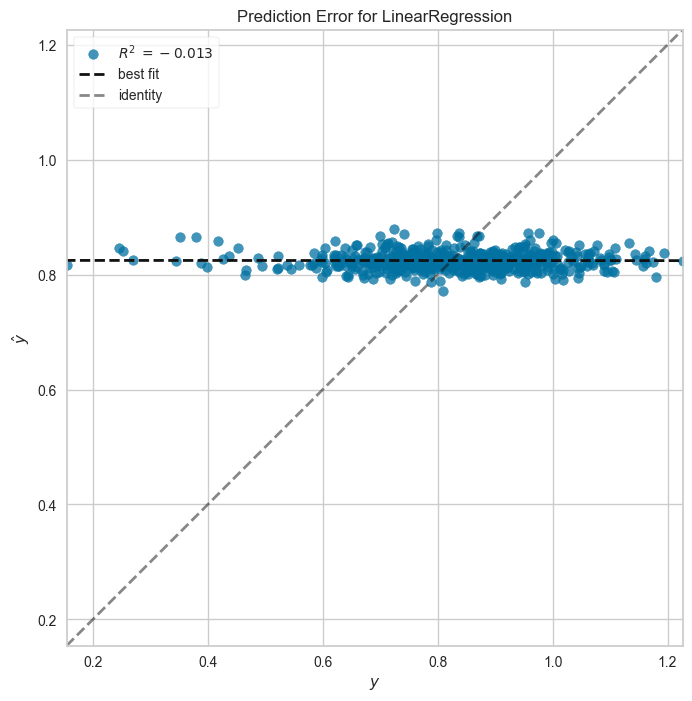

In [124]:
import matplotlib.pyplot as plt
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(8,8))
visualizer = prediction_error(lr, X_test_std, y_test, is_fitted=True)

### Ridge Regression

In [125]:
from sklearn.model_selection import cross_val_score
alpha = [1e-3, 1e-2, 1e-1, 1, 100]
from sklearn.linear_model import RidgeCV
ridge_cv = RidgeCV(alphas=alpha, scoring="r2", cv=5).fit(X_train_std, y_train)
ridge_r2_test= ridge_cv.score(X_test_std, y_test)
ridge_r2_val = ridge_cv.best_score_
ridge_r2_val2 = np.mean(cross_val_score( RidgeCV(alphas=alpha, scoring="r2", cv=5), X_train_std, y_train, scoring="r2" ))
ridge_r2_train= ridge_cv.score(X_train_std, y_train)

print("Train R2: ", ridge_r2_train)
print("Validation R2: ", ridge_r2_val)
print("Validation R2: ", ridge_r2_val2)

print("Test R2: ", ridge_r2_test)
print(ridge_cv.alpha_)

Train R2:  0.01285823031793809
Validation R2:  -0.0001508871638734366
Validation R2:  -0.0001508871638734366
Test R2:  -0.010081361977690939
100.0


### Lasso Regression

In [126]:
alpha = [1e-3, 1e-2, 1e-1, 1, 100]
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(cv=5, random_state=0, alphas=alpha).fit(X_train_std, y_train)
lasso_r2_test= lasso_cv.score(X_test_std, y_test)
lasso_r2_val = np.mean(cross_val_score( LassoCV(alphas=alpha, random_state=0, cv=5), X_train_std, y_train, scoring="r2" ))
lasso_r2_train= lasso_cv.score(X_train_std, y_train)

print("Train R2: ", lasso_r2_train)
print("Validation R2: ", lasso_r2_val)
print("Test R2: ", lasso_r2_test)
print(lasso_cv.alpha_)

Train R2:  0.0
Validation R2:  -0.004350795702174892
Test R2:  -0.0029815508162667204
100.0


In [127]:
r2_results = pd.DataFrame({'LR': lr_r2_train, 'Ridge': ridge_r2_train, 'Lasso': lasso_r2_train,}, index=['Train R2'])


print([lr_r2_val, ridge_r2_val, lasso_r2_val])
lr_r2_val = np.mean(lr_r2_val)
r2_results.loc['CV (Val) R2', :] = [lr_r2_val, ridge_r2_val, lasso_r2_val]
r2_results.loc['Test R2', :] = [lr_r2_test, ridge_r2_test, lasso_r2_test]


r2_results.loc['lambda','LR']=0
r2_results.loc['lambda','Ridge']=ridge_cv.alpha_
r2_results.loc['lambda','Lasso']=lasso_cv.alpha_
r2_results


[-0.004432451040111696, -0.0001508871638734366, -0.004350795702174892]


,LR,Ridge,Lasso
Train R2,0.014094,0.012858,0.000000
CV (Val) R2,-0.004432,-0.000151,-0.004351
Test R2,-0.013292,-0.010081,-0.002982
lambda,0.000000,100.000000,100.000000


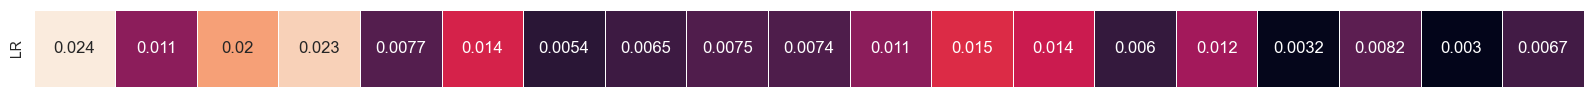

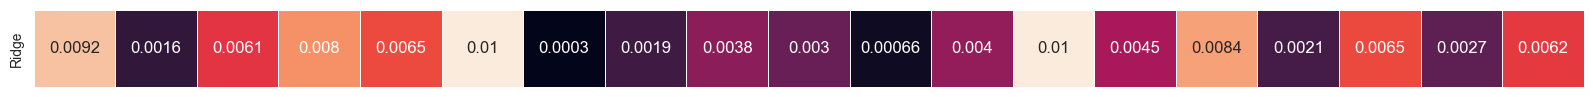

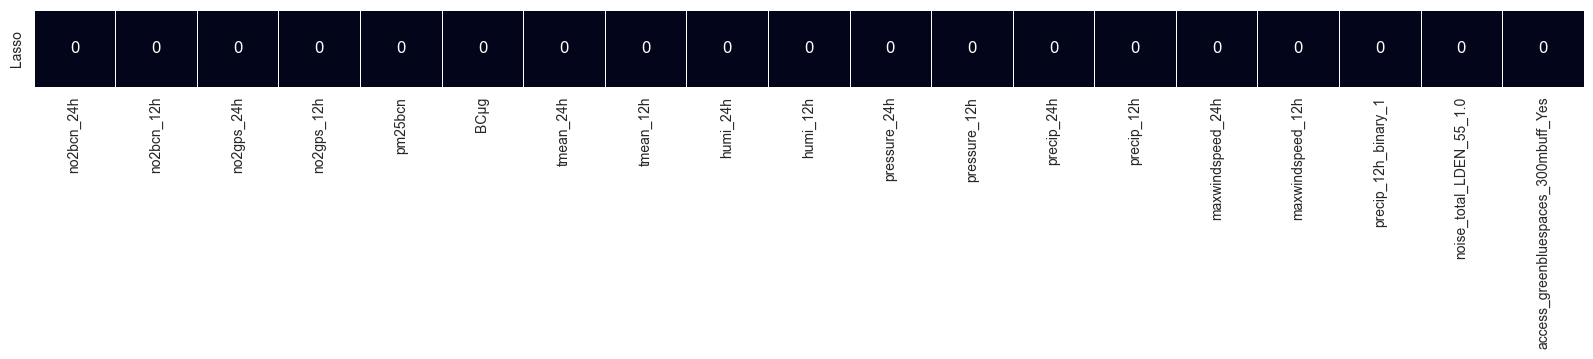

In [128]:

import matplotlib.pyplot as plt
import seaborn as sns

weights = pd.DataFrame({'LR':lr.coef_, 'Ridge':ridge_cv.coef_, 'Lasso':lasso_cv.coef_},index=X_train_std.columns)

fig, ax = plt.subplots(figsize = (20,1))
sns.heatmap(weights.T.loc[['LR'],:].abs(), annot=True, linewidths=.5, ax=ax, cbar=False, xticklabels=False);

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['Ridge'],:].abs(), annot=True, linewidths=.5, cbar=False, xticklabels=False);

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['Lasso'],:].abs(), annot=True, linewidths=.5, cbar=False, xticklabels=True);

# MLP

In [25]:
X_train_std_old = X_train_std.copy()
X_test_std_old = X_test_std.copy()

In [79]:
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,  Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist, fashion_mnist

from keras.optimizers import SGD, Adam
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, fetch_covtype, fetch_california_housing
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score

from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

callback = EarlyStopping(monitor='loss',patience=3)

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_std.shape[1],), kernel_regularizer=regularizers.l2(0.01)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(1)
])
# Define the optimizer and learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
callback = EarlyStopping(monitor='val_mean_squared_error',patience=15)

# Train the model
num_epochs = 2000
batch_size = 256
history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

# Evaluate the model
y_train_pred = model.predict(X_train_std)
y_test_pred = model.predict(X_test_std)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MSE: {:.4f}'.format(train_mse))
print('Testing MSE: {:.4f}'.format(test_mse))
print('Training R-squared: {:.4f}'.format(train_r2))
print('Testing R-squared: {:.4f}'.format(test_r2))



Epoch 1/2000


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.5624 - mean_squared_error: 0.4202 - val_loss: 3.0926 - val_mean_squared_error: 0.1375
Epoch 2/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.9768 - mean_squared_error: 0.0932 - val_loss: 2.7302 - val_mean_squared_error: 0.0721
Epoch 3/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6441 - mean_squared_error: 0.0565 - val_loss: 2.4111 - val_mean_squared_error: 0.0399
Epoch 4/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.3387 - mean_squared_error: 0.0346 - val_loss: 2.1309 - val_mean_squared_error: 0.0340
Epoch 5/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0654 - mean_squared_error: 0.0314 - val_loss: 1.8780 - val_mean_squared_error: 0.0335
Epoch 6/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8174 - mean_squared_error: 0.0289 - val_loss: 1.6464 - val_mean_squared_error: 0.0272
Epoch 7/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5961 - mean_squared_error: 0.0274 - val_loss: 1.4438 - val_mean_square

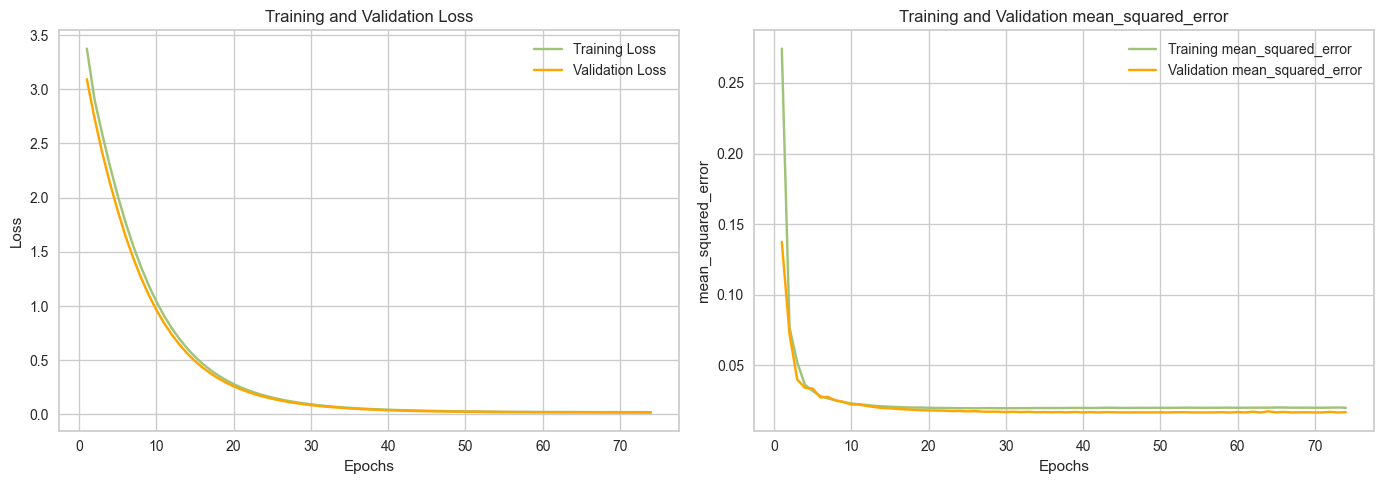

In [80]:
# Plot leaning curves
def plot_curves(history):

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_accuracy = history.history['mean_squared_error']
  val_accuracy = history.history['val_mean_squared_error']
  epochs = range(1, len(train_loss) + 1)

  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  axes[0].plot(epochs, train_loss, 'g-', label='Training Loss')
  axes[0].plot(epochs, val_loss, 'orange', label='Validation Loss')
  axes[0].set_title('Training and Validation Loss')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].legend()
  axes[0].grid(True)

  axes[1].plot(epochs, train_accuracy, 'g-', label='Training mean_squared_error')
  axes[1].plot(epochs, val_accuracy, 'orange', label='Validation mean_squared_error')
  axes[1].set_title('Training and Validation mean_squared_error')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('mean_squared_error')
  axes[1].legend()
  axes[1].grid(True)

  plt.tight_layout()

  plt.show()

plot_curves(history)

In [83]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(hidden_layer_sizes=(800, 800, 800,), random_state=1, max_iter=500).fit(X_train_std, y_train)
regr.score(X_test_std, y_test)

-0.0958497093328261